In [1]:
#Imports 
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_aug_train(url, cached=False):
    '''
    This function reads in url for aug_train data and writes data to
    a csv file if cached == False or if cached == True reads in germany df from
    a csv file, returns df.
    '''
    aug_train_df = pd.read_csv(url)
    
    if cached == False or os.path.isfile('aug_train.csv') == False:
        
        # Read fresh data from db into a DataFrame.
        df = aug_train_df
        
        # Write DataFrame to a csv file.
        df.to_csv('aug_train.csv')
        
    else:
        
        # If csv file exists or cached == True, read in data from csv.
        df = pd.read_csv('aug_train.csv', index_col=0)
        
    return df

In [3]:
def miss_dup_values(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values and duplicated rows,
    and the percent of that column that has missing values and duplicated rows
    '''
        # Total missing values
    mis_val = df.isnull().sum()
        # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        #total of duplicated
    dup = df.duplicated().sum()
        # Percentage of missing values
    dup_percent = 100 * dup / len(df)
        # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total null Values'})
        # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total null Values', ascending=False).round(1)
        # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")
    print( "  ")
    print (f"** There are {dup} duplicate rows that represents {round(dup_percent, 2)}% of total Values**")
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [4]:
#acquiring aug_train csv
aug_train_df= get_aug_train('archive/aug_train.csv')

In [5]:
aug_train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [6]:
# Looking at shape
aug_train_df.shape

(19158, 14)

In [7]:
#Looking at datatypes
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# Acquire Takeaways:
    - drop unnamed column 
    - drop or fill in nulls
    - change some of object datatypes to a numeric datatype

# Prepare

In [8]:
#Function to print unique values for each column
def report_unique_val (df):
    '''
    takes in a df and gives you a report of number of unique values and count values <15 (categorical)
    count values <15 (numerical)
    '''
    num_cols = df.select_dtypes(exclude = 'O').columns.to_list()
    cat_cols = df.select_dtypes(include = 'O').columns.to_list()
    for col in df.columns:
            print(f'**{col}**')
            le = df[col].nunique()
            print ('Unique Values : ', df[col].nunique())
            print(' ')
            if col in cat_cols and le < 124:
                print(df[col].value_counts())
            if col in num_cols and  le < 23:
                 print(df[col].value_counts().sort_index(ascending=True))
            elif col in num_cols and le <150:
                print(df[col].value_counts(bins=10, sort=False).sort_index(ascending=True))
            elif col in num_cols and le <1001:
                print(df[col].value_counts(bins=100, sort=False).sort_index(ascending=True))
            print('=====================================================')

In [9]:
#using function above
report_unique_val (aug_train_df)

**enrollee_id**
Unique Values :  19158
 
**city**
Unique Values :  123
 
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_121       3
city_111       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
**city_development_index**
Unique Values :  93
 
(0.446, 0.498]      63
(0.498, 0.548]     115
(0.548, 0.598]     547
(0.598, 0.648]    2750
(0.648, 0.698]    1081
(0.698, 0.749]     448
(0.749, 0.799]     962
(0.799, 0.849]     987
(0.849, 0.899]    2380
(0.899, 0.949]    9825
Name: city_development_index, dtype: int64
**gender**
Unique Values :  3
 
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
**relevent_experience**
Unique Values :  2
 
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
**enrolled_university**
Unique Values :  3
 
no_enrollment       13817
Full time course     3757
Part time course     1198

In [10]:
#Using function to see percentage of missing nulls in columns
miss_dup_values(aug_train_df)

Your selected dataframe has 14 columns.
There are 8 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total null Values
company_type,6140,32.0
company_size,5938,31.0
gender,4508,23.5
major_discipline,2813,14.7
education_level,460,2.4
last_new_job,423,2.2
enrolled_university,386,2.0
experience,65,0.3


In [11]:
#fill the gender column and company type nulls with other category
aug_train_df[['gender','company_type']] =aug_train_df[['gender','company_type']].fillna('Other')

In [12]:
#using unique value function to be sure Nulls were filled with other
report_unique_val (aug_train_df)

**enrollee_id**
Unique Values :  19158
 
**city**
Unique Values :  123
 
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_121       3
city_111       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
**city_development_index**
Unique Values :  93
 
(0.446, 0.498]      63
(0.498, 0.548]     115
(0.548, 0.598]     547
(0.598, 0.648]    2750
(0.648, 0.698]    1081
(0.698, 0.749]     448
(0.749, 0.799]     962
(0.799, 0.849]     987
(0.849, 0.899]    2380
(0.899, 0.949]    9825
Name: city_development_index, dtype: int64
**gender**
Unique Values :  3
 
Male      13221
Other      4699
Female     1238
Name: gender, dtype: int64
**relevent_experience**
Unique Values :  2
 
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
**enrolled_university**
Unique Values :  3
 
no_enrollment       13817
Full time course     3757
Part time course     1198

**Dropping nulls from the columns education_level, last_new_job, enrolled_university, and experience due to nulls being a small percentage**

In [13]:
# miss_dup_values(aug_train_df)

Using function of missing nulls to verify all nulls were dropped from education_level, last_new_job, enrolled_university, and experience columns

In [14]:
# miss_dup_values(aug_train_df)

In [15]:
#Drop any remaining nulls
# zillow_df= zillow_df.dropna()

In [16]:
#encode relevant experience
aug_train_df.relevent_experience.replace({'Has relevent experience': 1, 'No relevent experience': 0}, inplace = True)

In [17]:
#Verify relevant experience was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,Full time course,Graduate,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,Part time course,Graduate,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [18]:
#encode relevant experience
aug_train_df.enrolled_university.replace({'Part time course': 2,'Full time course': 1, 'no_enrollment': 0}, inplace = True)

In [19]:
#Verify enrolled university column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,0.0,Graduate,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,0.0,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,1.0,Graduate,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,0.0,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,2.0,Graduate,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,0.0,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,0.0,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,0.0,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,0.0,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [20]:
#encode education level
aug_train_df.education_level.replace({'Phd': 4, 'Masters': 3, 'Graduate': 2, 'High School': 1, 'Primary School': 0}, inplace = True)

In [21]:
#Verify education level column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,1,0.0,2.0,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,Male,0,0.0,2.0,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Other,0,1.0,2.0,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,Other,0,NaN,2.0,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,1,0.0,3.0,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Other,1,2.0,2.0,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,Male,1,0.0,1.0,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,1,0.0,2.0,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,1,0.0,2.0,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,Other,1,0.0,2.0,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [22]:
#encode gender 
aug_train_df.gender.replace({'Other': 2, 'Male': 1, 'Female': 0}, inplace = True)

In [23]:
#Verify gender column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,1,1,0.0,2.0,STEM,>20,NaN,Other,1,36,1.0
1,29725,city_40,0.776,1,0,0.0,2.0,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,2,0,1.0,2.0,STEM,5,NaN,Other,never,83,0.0
3,33241,city_115,0.789,2,0,NaN,2.0,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,1,1,0.0,3.0,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,2,1,2.0,2.0,STEM,11,NaN,Other,1,24,1.0
6,28806,city_160,0.920,1,1,0.0,1.0,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,1,1,0.0,2.0,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,1,1,0.0,2.0,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,2,1,0.0,2.0,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [24]:
#encode company type column 
aug_train_df.company_type.replace({'Other': 5, 'NGO': 4, 'Early Stage Startup': 3, 'Public Sector': 2, 'Funded Startup': 1, 'Pvt Ltd': 0}, inplace = True)

In [25]:
#Verify company type column was changed 
aug_train_df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,1,1,0.0,2.0,STEM,>20,NaN,5,1,36,1.0
1,29725,city_40,0.776,1,0,0.0,2.0,STEM,15,50-99,0,>4,47,0.0
2,11561,city_21,0.624,2,0,1.0,2.0,STEM,5,NaN,5,never,83,0.0
3,33241,city_115,0.789,2,0,NaN,2.0,Business Degree,<1,NaN,0,never,52,1.0
4,666,city_162,0.767,1,1,0.0,3.0,STEM,>20,50-99,1,4,8,0.0
5,21651,city_176,0.764,2,1,2.0,2.0,STEM,11,NaN,5,1,24,1.0
6,28806,city_160,0.920,1,1,0.0,1.0,NaN,5,50-99,1,1,24,0.0
7,402,city_46,0.762,1,1,0.0,2.0,STEM,13,<10,0,>4,18,1.0
8,27107,city_103,0.920,1,1,0.0,2.0,STEM,7,50-99,0,1,46,1.0
9,699,city_103,0.920,2,1,0.0,2.0,STEM,17,10000+,0,>4,123,0.0


In [26]:
#Looking at datatypes after column changes
aug_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  int64  
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     18772 non-null  float64
 6   education_level         18698 non-null  float64
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            19158 non-null  int64  
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(4), int64(5), object(5)
mem

In [27]:
# Using the missing duplicate function to see how many missing values we have
miss_dup_values(aug_train_df)

Your selected dataframe has 14 columns.
There are 6 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total null Values
company_size,5938,31.0
major_discipline,2813,14.7
education_level,460,2.4
last_new_job,423,2.2
enrolled_university,386,2.0
experience,65,0.3


# Explore

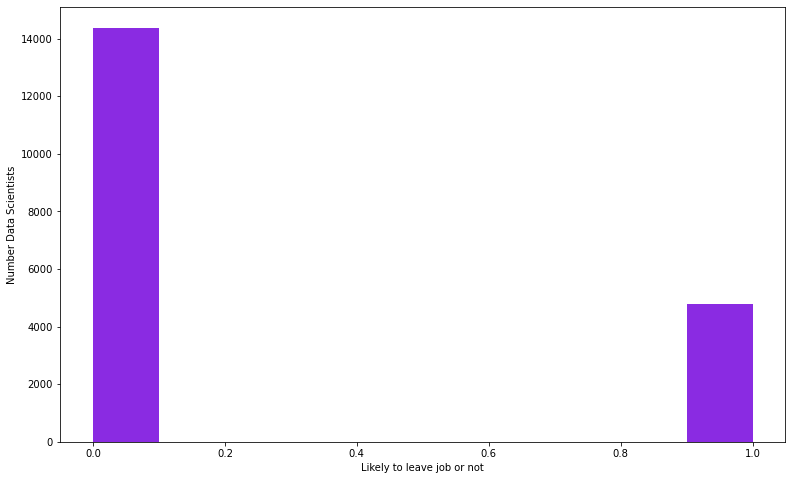

In [34]:
plt.figure(figsize=(13, 8))
aug_train_df['target'].hist(grid=False, color = 'blueviolet')
plt.xlabel("Likely to leave job or not")
plt.ylabel("Number Data Scientists")                               
plt.show()

# Evaluate and Model